# Example: Cargo flow plots 

This example demonstrates the workflow to import (persisted Vessels DB) and call (VoyagesAPI) the required data in order to replicate the cargo flow visualizations of either imports or exports from a specific load area and of a specific vessel class.

In [2]:
signal_ocean_api_key = '...' #replace with your subscription key

In [14]:
from signal_ocean import Connection
import pandas as pd
from datetime import datetime, date, timedelta, timezone

connection = Connection(signal_ocean_api_key)

## 1. Importing the data

### 1.1. Calling VoyagesAPI:

In [4]:
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.distances import DistancesAPI, VesselClassFilter

In [5]:
# Specify call parameters

area_of_interest = 'Australia West'
vessel_class = 'Capesize'                
date_from = date(2018,12,31)         # start_date_from
activity = 'export'                  # "import" or "export"

In [8]:
# Call VoyagesAPI() utilising DistancesAPI() filter

voyages_api = VoyagesAPI(connection)
distances_api = DistancesAPI(connection)

vessel_class_id = distances_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0].id  # extract vessel class id

voyages = voyages_api.get_voyages(vessel_class_id=vessel_class_id, date_from=date_from - timedelta(days=90)) # Feature Note: specify date column to use for date_from (i.e first_load_arrival_date). Temp fix: Since we are interested in first_load_arrival_date and not start_date, subtract 3 months from date_from to ensure all data-of-interest are included.
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

In [9]:
# Append neccessary cargo flow events

def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

In [10]:
# Filter voyages by "imports" or "exports"

def get_voyage_imports_exports(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise SyntaxError('activity must take values "import" or "export".')
        
voyages = get_voyage_imports_exports(voyages, activity)

In [15]:
# Clean any predicted data and keep only current/historical

voyages = voyages[pd.to_datetime(voyages['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)]
voyages

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,vessel_name,...,fixture_date,fixture_is_coa,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,laden_distance,load_area,load_country,discharge_country
136,9165322,68,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED41A3F00', port_id=8...",I8BDA0AVED41A3F00,Great Sunrise,...,NaT,None,None,None,None,3568.06,3721.32,Australia West,Australia,Japan
137,9165322,69,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4695900', port_id=8...",I8BDA0AVED4695900,Great Sunrise,...,NaT,None,None,None,None,3559.00,3699.87,Australia West,Australia,Japan
138,9165322,70,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4B87300', port_id=8...",I8BDA0AVED4B87300,Great Sunrise,...,NaT,None,None,None,None,3567.84,3639.62,Australia West,Australia,Japan
142,9165322,74,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6930F00', port_id=8...",I8BDA0AVED6930F00,Great Sunrise,...,NaT,None,None,None,None,3537.96,3562.22,Australia West,Australia,Japan
143,9165322,75,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6E22900', port_id=8...",I8BDA0AVED6E22900,Great Sunrise,...,NaT,None,None,None,None,3565.06,3601.37,Australia West,Australia,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22173,9889306,2,3,70,1,-1,False,"(VoyageEvent(id='I96E61ASED7CF7700', port_id=8...",I96E61AVED7CF7700,Azul Tierra,...,NaT,None,None,None,None,3476.59,3597.32,Australia West,Australia,Japan
22177,9891907,1,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7A7EA00', port_id=6...",I96F043VED7A7EA00,Southern Cross,...,NaT,None,None,None,None,3647.09,3751.90,Australia West,Australia,Japan
22178,9891907,2,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7F70400', port_id=3...",I96F043VED7F70400,Southern Cross,...,NaT,None,None,None,None,3579.16,4083.63,Australia West,Australia,Japan
22189,9906013,2,3,70,1,-1,False,"(VoyageEvent(id='I97275DSED81E9100', port_id=6...",I97275DVED81E9100,Trust Qingdao,...,NaT,None,None,None,None,3754.81,3.60,Australia West,Australia,China


### 1.2. Import Persisted Vessel data:

In [16]:
import sqlite3

db_conn = sqlite3.connect('AllVessels.db')

query = db_conn.execute("SELECT imo,deadweight FROM Vessels") # extract only imo, deadweight columns
cols = [column[0] for column in query.description]
vessels = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)

db_conn.close()

vessels

,imo,deadweight
0,-2,0
1,-1,0
2,2228228,20420
3,5000172,269
4,5000201,590
...,...,...
43386,9920411,60000
43387,9922067,2874
43388,9922859,4820
43389,9922861,4820


### 1.3. Merge Voyage & Vessel data:

In [17]:
# Merge data and keep only useful info

voyages_merged = voyages.merge(vessels, on='imo')
voyages_merged = voyages_merged[['first_load_arrival_date','imo','voyage_number','deadweight','load_area','load_country','discharge_country']].sort_values('first_load_arrival_date').reset_index(drop=True)

voyages_merged

,first_load_arrival_date,imo,voyage_number,deadweight,load_area,load_country,discharge_country
0,2018-10-08 11:53:52+00:00,9816555,6,208660,Australia West,Australia,Taiwan
1,2018-10-13 03:57:47+00:00,9304942,95,203512,Australia West,Australia,Taiwan
2,2018-10-13 07:59:58+00:00,9395197,55,178022,Australia West,Australia,China
3,2018-10-13 11:56:56+00:00,9458690,56,179719,Australia West,Australia,China
4,2018-10-14 03:58:08+00:00,9573115,39,179147,Australia West,Australia,China
...,...,...,...,...,...,...,...
10183,2021-05-31 09:52:47.476000+00:00,9648295,50,206000,Australia West,Australia,China
10184,2021-05-31 10:14:47.588000+00:00,9565326,83,180090,Australia West,Australia,China
10185,2021-05-31 10:37:44.671000+00:00,9573737,55,181447,Australia West,Australia,China
10186,2021-05-31 10:47:10.016000+00:00,9849239,8,208000,Australia West,Australia,China


## 2. Plotting the data

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 2.1. Plot: Volume per Week

In [19]:
# Create bins of weeks-of-interest

dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') # time-beggining

weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])

weeks_from_monday

,first_load_arrival_date
0,2018-12-31 00:00:00+00:00
1,2019-01-07 00:00:00+00:00
2,2019-01-14 00:00:00+00:00
3,2019-01-21 00:00:00+00:00
4,2019-01-28 00:00:00+00:00
...,...
122,2021-05-03 00:00:00+00:00
123,2021-05-10 00:00:00+00:00
124,2021-05-17 00:00:00+00:00
125,2021-05-24 00:00:00+00:00


In [20]:
# Group voyages into weekly bins (starting from Monday) and aggregate(SUM)

volume_per_week = voyages_merged[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()

volume_per_week

,first_load_arrival_date,deadweight
0,2018-10-08 00:00:00+00:00,208660
1,2018-10-15 00:00:00+00:00,2096236
2,2018-10-22 00:00:00+00:00,13994516
3,2018-10-29 00:00:00+00:00,14037373
4,2018-11-05 00:00:00+00:00,13462300
...,...,...
134,2021-05-03 00:00:00+00:00,17245724
135,2021-05-10 00:00:00+00:00,12073187
136,2021-05-17 00:00:00+00:00,16280350
137,2021-05-24 00:00:00+00:00,13725019


In [21]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes

volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,14.818093
1,2019-01-07 00:00:00+00:00,11.497005
2,2019-01-14 00:00:00+00:00,11.147890
3,2019-01-21 00:00:00+00:00,14.712413
4,2019-01-28 00:00:00+00:00,11.729516
...,...,...
122,2021-05-03 00:00:00+00:00,17.245724
123,2021-05-10 00:00:00+00:00,12.073187
124,2021-05-17 00:00:00+00:00,16.280350
125,2021-05-24 00:00:00+00:00,13.725019


(0.0, 26.192026900000002)

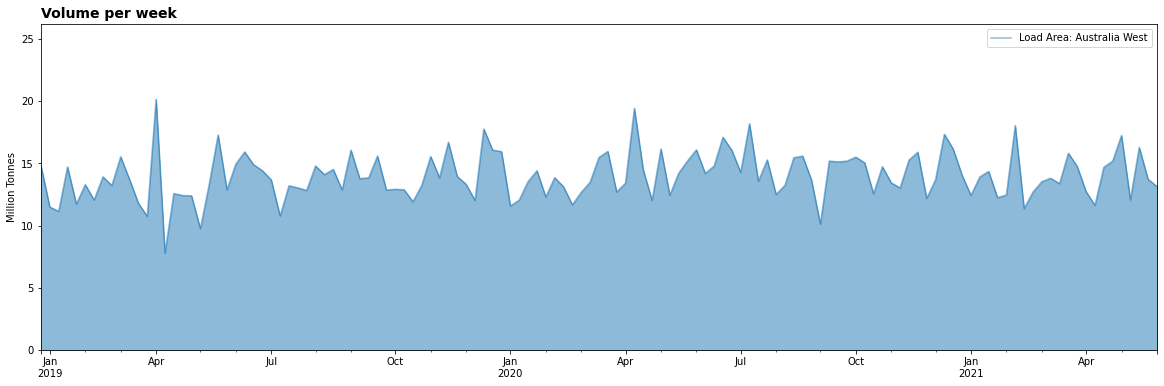

In [55]:
# PLOT volume per week
fig, axs = plt.subplots(figsize=(20,6))

volume_per_week.plot(ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False, xlabel='', ylabel='Million Tonnes')

# Properties
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])

axs.set_ylim([0, 1.3*max(volume_per_week['deadweight'])])
#fmt_month = mdates.MonthLocator(interval=1)
#axs.xaxis.set_major_locator(fmt_month)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %Y'))
#axs.set_xticks(pd.date_range(start=, end=date.today(), freq='M'))

### 2.2. Plot: Countries of Destination

In [23]:
# Filter voyages by date
date_from = date(2021,1,1)  # SPECIFY new starting date

countries_of_destination = voyages_merged.loc[voyages_merged['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
countries_of_destination

,first_load_arrival_date,imo,voyage_number,deadweight,load_area,load_country,discharge_country
0,2021-01-01 03:59:25+00:00,9511349,48,176967,Australia West,Australia,China
1,2021-01-01 03:59:29+00:00,9736951,36,182651,Australia West,Australia,China
2,2021-01-01 03:59:51+00:00,9637791,75,180355,Australia West,Australia,China
3,2021-01-01 07:59:35+00:00,9713052,30,209067,Australia West,Australia,China
4,2021-01-01 11:54:31+00:00,9757175,27,208013,Australia West,Australia,China
...,...,...,...,...,...,...,...
1579,2021-05-31 09:52:47.476000+00:00,9648295,50,206000,Australia West,Australia,China
1580,2021-05-31 10:14:47.588000+00:00,9565326,83,180090,Australia West,Australia,China
1581,2021-05-31 10:37:44.671000+00:00,9573737,55,181447,Australia West,Australia,China
1582,2021-05-31 10:47:10.016000+00:00,9849239,8,208000,Australia West,Australia,China


In [24]:
# Group merged voyages by discharge country

countries_of_destination = voyages_merged.groupby(pd.Grouper(key='discharge_country')).sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)
countries_of_destination['%_deadweight'] = 100*countries_of_destination['deadweight']/countries_of_destination['deadweight'].sum()

countries_of_destination

,discharge_country,imo,voyage_number,deadweight,%_deadweight
0,New Zealand,9461269,55,169092,0.008834
1,Turkey,9363015,59,177987,0.009299
2,United Arab Emirates,9834129,7,186000,0.009718
3,United Kingdom,28520209,147,534116,0.027905
4,Netherlands,38192868,208,741670,0.038749
5,India,105888185,303,2228398,0.116423
6,Malaysia,420723946,2379,7929502,0.414278
7,Australia,578839081,3192,10841045,0.566392
8,Indonesia,606437566,2678,11915978,0.622552
9,Viet Nam,1035025597,5195,19602902,1.024156


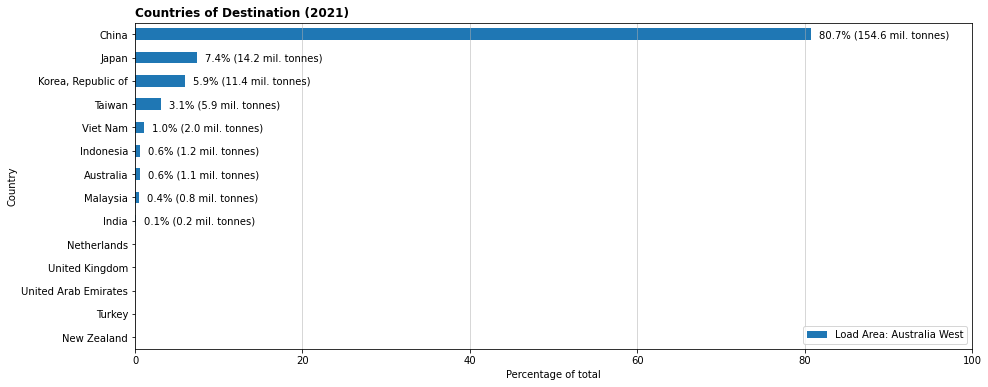

In [105]:
# PLOT countries of destination
fig, axs = plt.subplots(figsize=(15,6))

countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left', fontweight='bold')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

axs.set_xlim([0, 100])
axs.grid(which='major', axis='x', linewidth=0.5)

for i, v in enumerate(round(countries_of_destination['%_deadweight'],1)):
    if countries_of_destination['%_deadweight'][i] >= 0.1:
        dwt = countries_of_destination['deadweight'][i]
        axs.text(v + 1, i - 0.15, f'{v}% ({round(dwt/10e6,1)} mil. tonnes)', color='black')
    

In [26]:
# TODO: as far as plots are considered
# Volume per Week:
# - Make xticks tick monthly

# Make both plots into a function (taking dataseries as inputs instead of dataframes(?))